# Writing Rules for Non-Objective C Malware

Today we're going to inspect another DPRK malware family ported to MacOS: Dacls AKA Mata. Unlike RokRAT/CloudMensis that we previously inspected, this is not written in Objective C, so it'll change our workflow a bit. Mostly that means less intermediate tools and more time in a disassembler This comes in a DMG package that we can assess at another time; we'll focus on the embedded payload. A number of entities have discussed this particular sample:  

[MalwareBytes](https://www.malwarebytes.com/blog/news/2020/05/new-mac-variant-of-lazarus-dacls-rat-distributed-via-trojanized-2fa-app)
[Patrick Wardle](https://objective-see.org/blog/blog_0x57.html)
[Phil Stokes](https://twitter.com/philofishal/status/1257669351899086849)
[Kaspersky GREaT](https://securelist.com/mata-multi-platform-targeted-malware-framework/97746/)
[SentinelLabs](https://www.sentinelone.com/blog/four-distinct-families-of-lazarus-malware-target-apples-macos-platform/)
[Kaspersky GREaT](https://securelist.com/lazarus-on-the-hunt-for-big-game/97757/)

Lets jump right into it! Off the bat, checking the section names we can tell this is not written in Objective-C. Let's go right into the strings, including some function names! As we discussed yesterday, we can also check out whats in the `__LINKEDIT` segment to get function names, referenced symbols in the code, and more! MATA's `__LINKEDIT` segment  contains a ton function names, both from the wolfSSL library (shout out Steve Miller) and from the malware dev! How do we know that? well a ton of them are named MATA:

In [4]:
!emit /Users/glesnewich/Projects/Malware/Dacls/SubMenu.nib | vsect __LINKEDIT | carve printable --min=10 -t 100 -x | sort

0url_encodePcS_
2mata_strcmp_startswithPKcS0_
4ReverseShellBridgeThreadP9_CMataNet
6ConvertEndianUnicodeStringPwm
7CMataNet_
8CMataNet_
8spt_initiPPc
@__DefaultRuneLocale
@____chkstk_darwin
@___maskrune
@___memcpy_chk
@___memset_chk
@___snprintf_chk
@___stack_chk_fail
@___stack_chk_guard
@___strncat_chk
@___strncpy_chk
@___tolower
@___toupper
@___udivti3
@_alphasort$INODE64
@_closedir
@_daemon$1050
@_freeaddrinfo
@_getaddrinfo
@_gethostbyname
@_gethostname
@_getprogname
@_getpwuid
@_inet_addr
@_inet_ntoa
@_inet_ntop
@_localtime
@_opendir$INODE64
@_pthread_create
@_pthread_detach
@_pthread_exit
@_pthread_mutex_destroy
@_pthread_mutex_init
@_pthread_mutex_lock
@_pthread_mutex_unlock
@_pthread_self
@_readdir$INODE64
@_realpath$DARWIN_EXTSN
@_scandir$INODE64
@_select$1050
@_setprogname
@_setsockopt
@_snprintf
@_stat$INODE64
@_strcasestr
@_strftime
@_strncasecmp
@_vsnprintf
@dyld_stub_binder
ARARARARARARARARARARARARARARARARARARARARARARARB
AuthP9_CMataNetPcs
CMataNet_Createi
CMataNet_SSL
CMa

Okay so even some of these names alone are useful for us to assume functionality (some rc4, some http references, some general things like getting the hostname) as well as likely unique strings. If we just look for strings in that segment that contain MataNet, we get a nice tidy list:

```
4ReverseShellBridgeThreadP9_CMataNet
7CMataNet_
8CMataNet_
AuthP9_CMataNetPcs
CMataNet_
CMataNet_
CMataNet_Createi
CMataNet_SSL
CMataNet_SSLHandshakeP9_CMataNet
CMataNet_SSLRecvPartialP9_CMataNetPvii
CloseSSLP9_CMataNet
CloseSocketP9_CMataNet
ExchangeKeyP9_CMataNeti
FreeP9_CMataNet
MataNet_swap_bytesP9_CMataNetPhS1_
RecvBlockP9_CMataNetPviii
RecvP9_CMataNetPvii
SendP9_CMataNetPvi
WaitRecvP9_CMataNetj
__Z13CMataNet_AuthP9_CMataNetPcs
__Z13CMataNet_FreeP9_CMataNet
__Z15CMataNet_Createi
__Z16CMataNet_SSLRecvP9_CMataNetPvii
__Z16CMataNet_SSLSendP9_CMataNetPvi
__Z17CMataNet_CloseSSLP9_CMataNet
__Z17CMataNet_WaitRecvP9_CMataNetj
__Z17CMataNet_rc4_initP9_CMataNetP9rc4_statePKhi
__Z18CMataNet_RecvBlockP9_CMataNetPviii
__Z18CMataNet_SendBlockP9_CMataNetPvii
__Z18CMataNet_SetSocketP9_CMataNeti
__Z18CMataNet_rc4_cryptP9_CMataNetP9rc4_statePKhPhi
__Z19CMataNet_swap_bytesP9_CMataNetPhS1_
__Z20CMataNet_CloseSocketP9_CMataNet
__Z20CMataNet_ExchangeKeyP9_CMataNeti
__Z21CMataNet_SSLHandshakeP9_CMataNet
__Z23CMataNet_SSLRecvPartialP9_CMataNetPvii
__Z24ReverseShellBridgeThreadP9_CMataNet
_g_pMataNet
ndBlockP9_CMataNetPvii
rc4_cryptP9_CMataNetP9rc4_statePKhPhi
rc4_initP9_CMataNetP9rc4_statePKhi
tSocketP9_CMataNeti
```

Seems like good signature value eh? Lets also check `__TEXT/__cstring` for since, as we discussed in a previous post, it'll contain string literals used in the binary. Idk what literals means here to be totally honest but there are usually interesting strings in here! 

In [6]:
!emit /Users/glesnewich/Projects/Malware/Dacls/SubMenu.nib | vsect __TEXT/__cstring | carve printable --min=10 -t 40 -x 

c_2910.cls
k_3872.cls
POST/%sHTTP/1.0
User-Agent:Mozilla/5.0(WindowsNT10.0;Win64;x64)AppleWebKit/537.36(KHTML,likeGecko)Chrome/65.0.3325.181Safari/537.36
Accept:text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8
Accept-Language:en-us,en;q=0.5
Accept-Charset:ISO-8859-1,utf-8;q=0.7,*;q=0.7
Cache-Control:no-cache
Connection:close
Content-Length:%d
Content-Type:application/x-www-form-urlencoded
0123456789ABCDEF
/Library/Caches/com.apple.appstore.db
HTTP/1.0200OK
HTTP/1.1200OK
Content-Length
/proc/%d/task
/proc/%d/cmdline
/proc/%d/status
{"result":"ok"}
session_id
%Y-%m-%d%X
SCAN%s%d.%d.%d.%d%d
<?xmlversion="1.0"encoding="UTF-8"?><!DOCTYPEplistPUBLIC"-//Apple//DTDPLIST1.0//EN""http://www.apple.com/DTDs/PropertyList-1.0.dtd"><plistversion="1.0"><dict><key>Label</key><string>com.aex-loop.agent</string><key>ProgramArguments</key><array><string>%s</string><string>daemon</string></array><key>KeepAlive</key><false/><key>RunAtLoad</key><true/></dict></plist>
/Library/LaunchAgents/com.

As we can see lotta HTTP related stuff, some plist fun, some debug strings, filenames, and a lot of other unrelated stuff from stuffing in WolfSSL. Checking these strings early on can help us focus on whats important to hone in on in the disassembly! 

Let's keep it moving and jump into disassembly 

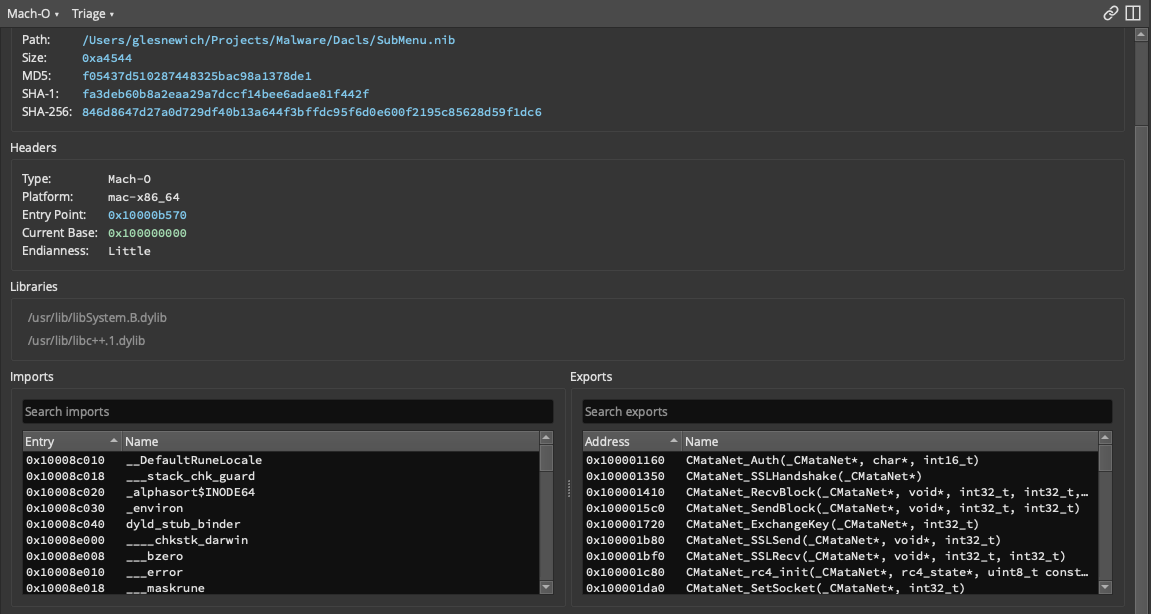

Immediately in triage view, we can see a ton of these MataNet function names are listed as exports by Binja. Why is that interesting? Well it likely means we are dealing with a modular framework, where other plugins might use the main Mata binary for some of their functionality to keep them as lightweight as possible. 

Moving into the main function (which Binary Ninja highlights for us), we can immediately see some probable stack strings! 

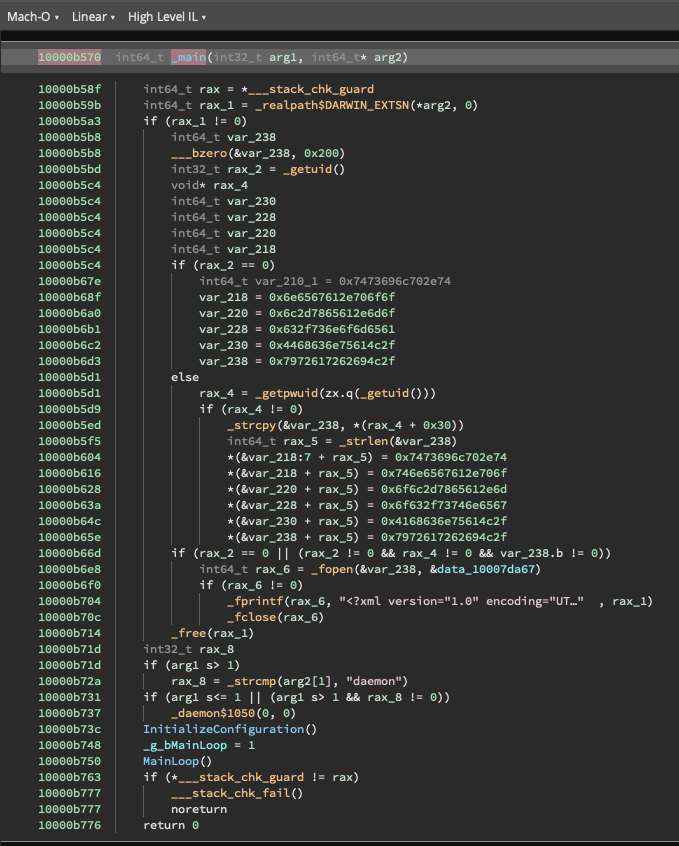

Printing the MLIL here since HLIL does not seem to be grabable via the Binja API:
```
>>> ff = bv.get_function_at(here)
>>> for i in ff.mlil_instructions:
... 	print("0x%x %s" % (i.address, i))
... 
0x10000b582 r15 = arg2
0x10000b585 r14 = arg1
0x10000b58f rax = [___stack_chk_guard].q
0x10000b592 var_30 = rax
0x10000b596 rdi = [arg2].q
0x10000b59b rax_1 = 0x100079092(rdi, 0)
0x10000b5a3 if (rax_1 == 0) then 7 @ 0x10000b71d else 8 @ 0x10000b5a9
0x10000b71d if (r14 s<= 1) then 13 @ 0x10000b737 else 15 @ 0x10000b71f
0x10000b5a9 r12_1 = rax_1
0x10000b5ac rdi_1 = &var_238
0x10000b5b8 0x100078ebe(rdi_1, 0x200)
0x10000b5bd rax_2 = 0x100078fd2()
0x10000b5c4 if (rax_2 == 0) then 18 @ 0x10000b67e else 25 @ 0x10000b5ca
0x10000b737 0x100078f3c(0, 0)
0x10000b737 goto 29 @ 0x10000b73c
0x10000b71f rdi_9 = [r15 + 8].q
0x10000b72a rax_8 = 0x10007910a(rdi_9, "daemon")
0x10000b731 if (rax_8 == 0) then 29 @ 0x10000b73c else 13 @ 0x10000b737
0x10000b67e var_210_1 = 0x7473696c702e74
0x10000b68f var_218 = 0x6e6567612e706f6f
0x10000b6a0 var_220 = 0x6c2d7865612e6d6f
0x10000b6b1 var_228 = 0x632f736e6f6d6561
0x10000b6c2 var_230 = 0x4468636e75614c2f
0x10000b6d3 var_238 = 0x7972617262694c2f
0x10000b6d3 goto 35 @ 0x10000b6e1
0x10000b5ca rax_3 = 0x100078fd2()
0x10000b5cf rdi_2 = zx.q(rax_3)
0x10000b5d1 rax_4 = 0x100078fcc(rdi_2)
0x10000b5d9 if (rax_4 == 0) then 38 @ 0x10000b711 else 41 @ 0x10000b5df
0x10000b73c 0x100004b90()
0x10000b748 [0x10009c3c0].d = 1
0x10000b74e rdi_10 = 0
0x10000b750 0x100005900()
0x10000b75c rax_9 = [___stack_chk_guard].q
0x10000b763 if (rax_9 != var_30) then 53 @ 0x10000b777 else 55 @ 0x10000b765
0x10000b6e1 rdi_5 = &var_238
0x10000b6e8 rax_6 = 0x100078f66(rdi_5, 0x10007da67)
0x10000b6f0 if (rax_6 == 0) then 38 @ 0x10000b711 else 57 @ 0x10000b6f2
0x10000b711 rdi_8 = r12_1
0x10000b714 0x100078f84(rdi_8)
0x10000b714 goto 7 @ 0x10000b71d
0x10000b5df rsi = [rax_4 + 0x30].q
0x10000b5ea rdi_3 = &var_238
0x10000b5ed 0x100079110(rdi_3, rsi)
0x10000b5f2 rdi_4 = &var_238
0x10000b5f5 rax_5 = 0x100079122(rdi_4)
0x10000b604 [&var_218:7 + rax_5].q = 0x7473696c702e74
0x10000b616 [&var_218 + rax_5].q = 0x746e6567612e706f
0x10000b628 [&var_220 + rax_5].q = 0x6f6c2d7865612e6d
0x10000b63a [&var_228 + rax_5].q = 0x6f632f73746e6567
0x10000b64c [&var_230 + rax_5].q = 0x4168636e75614c2f
0x10000b65e [&var_238 + rax_5].q = 0x7972617262694c2f
0x10000b66d if (var_238:0.b != 0) then 35 @ 0x10000b6e1 else 65 @ 0x10000b66f
0x10000b777 0x100078ee2()
0x10000b777 noreturn
0x10000b765 rax_10 = 0
0x10000b776 return 0
0x10000b6f2 rbx_1 = rax_6
0x10000b6fc rdi_6 = rax_6
0x10000b6ff rdx_1 = r12_1
0x10000b702 rax_7 = 0
0x10000b704 0x100078f72(rdi_6, "<?xml version="1.0" encoding="UT…", rdx_1)
0x10000b709 rdi_7 = rbx_1
0x10000b70c 0x100078f4e(rdi_7)
0x10000b70c goto 38 @ 0x10000b711
0x10000b66f goto 38 @ 0x10000b711
```


Converting those hex chunks into chars with `r` key we can see some fun stuff stored as stack strings:

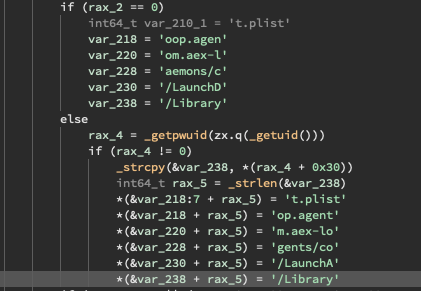

They reference PList files in LaunchDaemons and LaunchAgents folders. Remember yesterday when we were not sure what made a given thing in a Macho sample suspect? Well stack strings almost always are suspicious, so lets create a loose rule for the term `Library` being passed to the stack:

```
rule SUSP_Macho_Library_StackString
{
    meta:
        author = "Greg Lesnewich"
        date = "2023-01-18"
        version = "1.0"
        description = "check for the path /Library being passed as a stack string"

    strings:
        $slash_library = {48 ?? 2f 4c 69 62 72 61 72 79} // Library passed to stack with the register wildcarded

    condition:
        (uint32be(0x0) == 0xCAFEBABE or uint32be(0x0) == 0xCFFAEDFE or uint32be(0x0) == 0xCEFAEDFE) and 
		1 of them
}
```

I'll be sure to tinker around for modifications of the Library with capitals, removing the slash, and more.

Further down the main function, we can see two function calls: InitializeConfiguration() and MainLoop(). InitializeConfiguration does exactly what is says it does, loading IP addresses into some buffers. 

```
0x100004b9b rdi = &var_20
0x100004b9f rax = 0x100079140(rdi)
0x100004ba4 rdi_1 = zx.q(rax)
0x100004ba6 0x1000790ec(rdi_1)
0x100004bb2 rdi_2 = 0x10009c3c4
0x100004bb5 rax_1 = 0x100004c60()
0x100004bbc if (rax_1 == 0) then 7 @ 0x100004c53 else 9 @ 0x100004bca
0x100004c53 rax_4 = 0
0x100004c53 goto 33 @ 0x100004c5d
0x100004bca 0x100078ebe(0x10009c3c4, 0x8e14)
0x100004bcf rax_2 = 0x10007907a()
0x100004bd4 rax_3 = sx.q(rax_2)
0x100004bd6 rcx_1 = rax_3 * -0x7fffff7f
0x100004bdd rcx_2 = (rcx_1 u>> 0x20).d
0x100004be1 rcx_3 = rcx_2 + rax_3.eax
0x100004be3 rdx_1 = rcx_3
0x100004be5 rdx_2 = rdx_1 u>> 0x1f
0x100004be8 rcx_4 = rcx_3 s>> 0x17
0x100004beb rcx_5 = rcx_4 + rdx_2
0x100004bed rdx_3 = rcx_5
0x100004bef rdx_4 = rdx_3 << 0x18
0x100004bf2 rcx_6 = rcx_5 - rdx_4
0x100004bf4 rcx_7 = rcx_6 + rax_3.eax
0x100004bf6 [0x10009c3c4].d = rcx_7
0x100004c02 [0x10009c3c8].q = 0x1343b8400030100
0x100004c06 [0x10009c42c].d = 3
0x100004c18 0x1000039d0(0x10009c430, "67.43.239.146:443")
0x100004c2e 0x1000039d0(0x10009cc30, "185.62.58.207:443")
0x100004c3d 0x1000039d0(0x10009d430, "185.62.58.207:443")
0x100004c42 [0x10009c3d0].d = 2
0x100004c49 rdi_3 = 0x10009c3c4
0x100004c4c rax_4 = SaveConfig()
0x100004c51 goto 33 @ 0x100004c5d
0x100004c5d return rax_4
```

At the end it calls SaveConfig() which does some more interesting stuff:

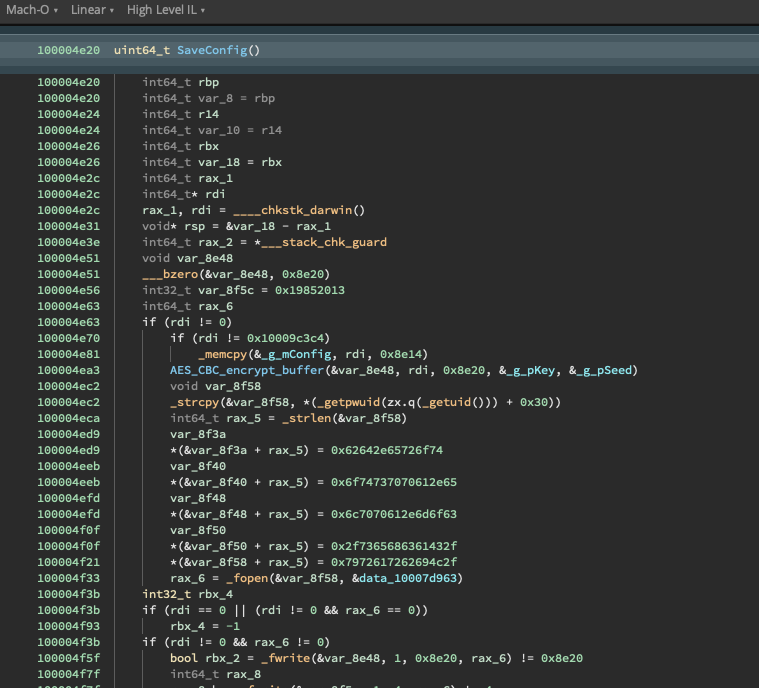

right off the bat we can see some AES functions and maybe more stack strings! 

Wheeee and decoding the stack strings we get a reference to a Cache folder containing a com.apple DB 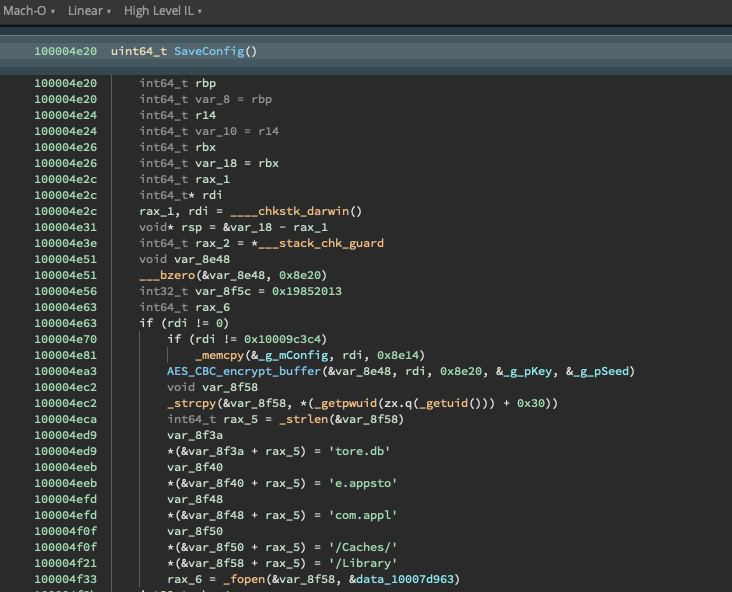

This is another suspect thing we could turn into a stack string YARA rule! going into the AES function there is a ton of variable manipulation that happens, maybe that could also be a useful signature for us? we can copy the hex directly since there are no embedded addresses or function calls we need to wild card!

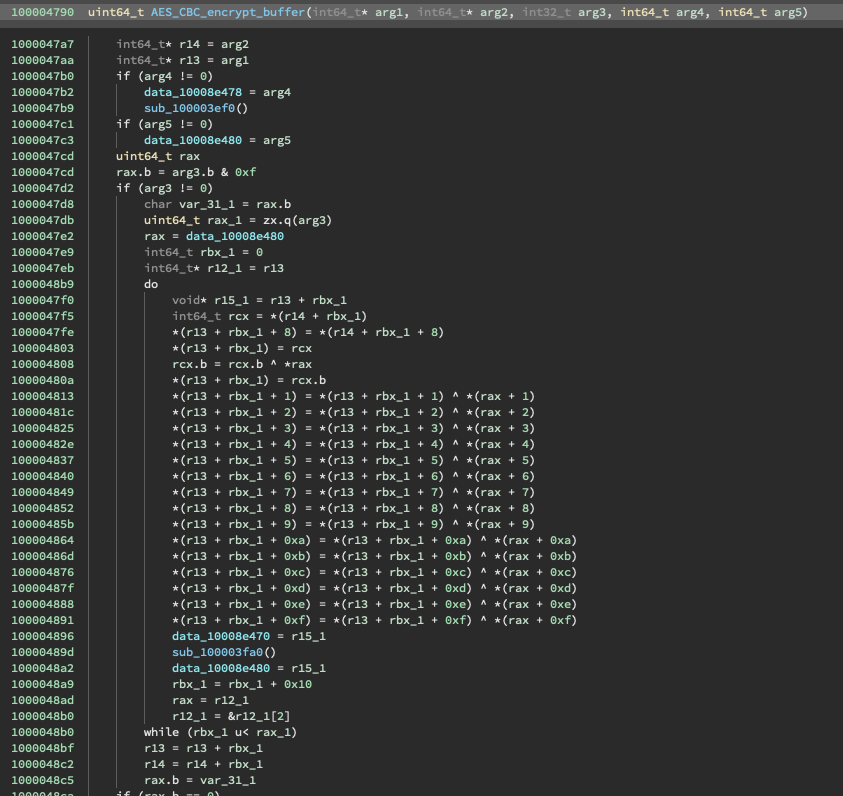

```
rule SUSP_Macho_AES_CBC_Mode_XOR
{
		meta:
				author = "Greg Lesnewich"
				date = "2023-01-18"
				version = "1.0"
				description = "check Macho files for what might be an AES XOR routine used in its CBC mode "

		strings:
				$aes_cbc_xor_movs = {0fb6480141304c1d010fb6480241304c1d020fb6480341304c1d030fb6480441304c1d040fb6480541304c1d050fb6480641304c1d060fb6480741304c1d070fb6480841304c1d080fb6480941304c1d090fb6480a41304c1d0a0fb6480b41304c1d0b0fb6480c41304c1d0c0fb6480d41304c1d0d0fb6480e41304c1d0e0fb6400f4130441d0f}
		condition:
				(uint32be(0x0) == 0xCAFEBABE or uint32be(0x0) == 0xCFFAEDFE or uint32be(0x0) == 0xCEFAEDFE) and
				1 of them
}
```

Okay I think we've burrowed deeply enough on InitializeConfiguration(), lets check out MainLoop()

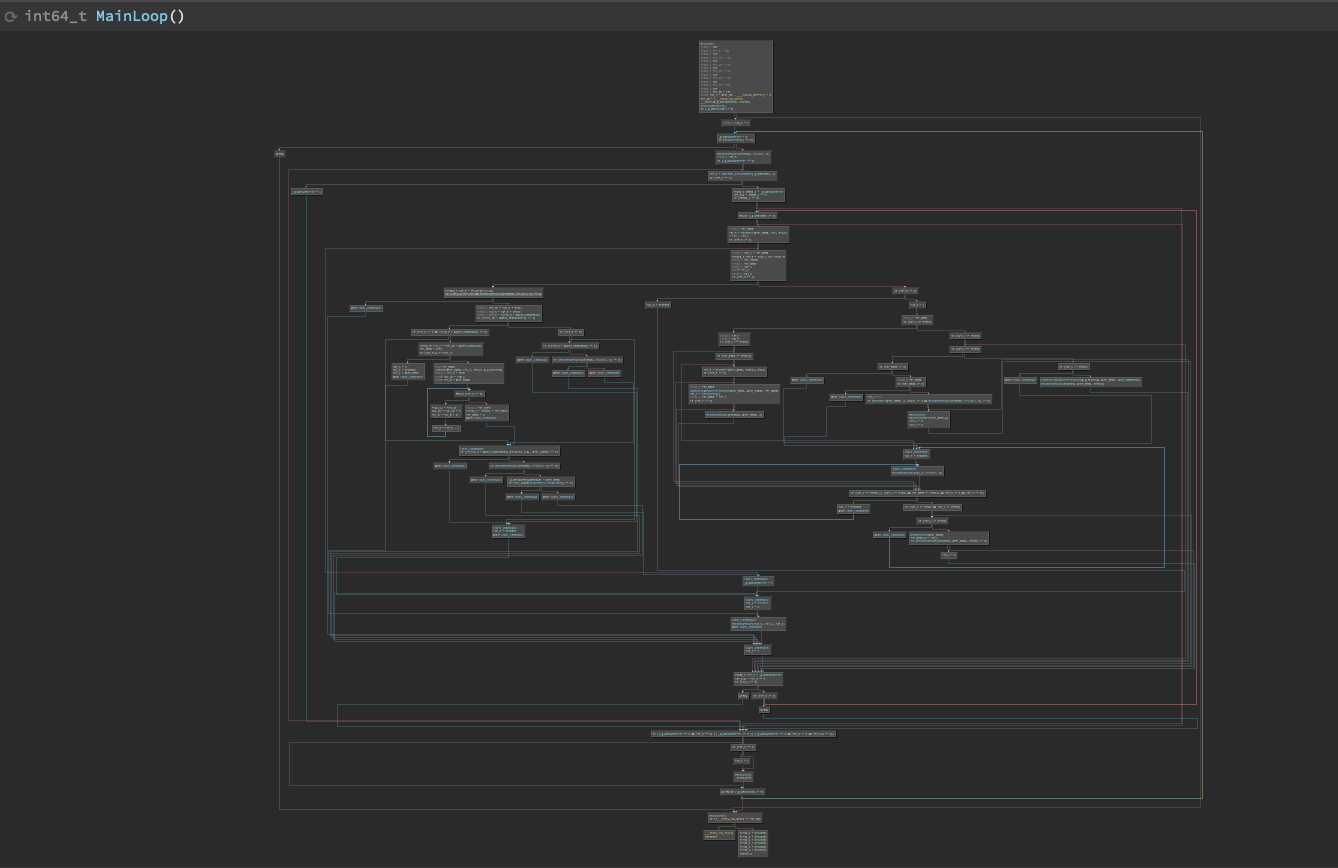

Holy crow thats a lotta jumps but off the bat we can see some interesting function calls to: 
- AutoLoadPlugins()
- MataConnect()
- MataSendPacket()
- CMataNet_ExchangeKey()

So we can assume that the main functionality here is to load plugins and connect to one of the C2's we saw previously. For a much better deep dive on MATA's protocol and identifying additional C2's, one must read [Active C2 Discovery Using Protocol Emulation Part4 (Dacls, aka MATA)](https://blogs.vmware.com/security/2022/11/threat-analysis-active-c2-discovery-using-protocol-emulation-part4-dacls-aka-mata.html) from one of my favorite researchers, Takahiro Haruyama. In the main loop, he found a number of constants get referenced in the beacon packet, which I would assume are used consistently across the MATA platform:

![](https://blogs.vmware.com/security/files/2022/11/Screen-Shot-2022-11-18-at-11.40.43-AM.png)


we can see the references to MataSendPacket with some of those constants in the MainLoop function

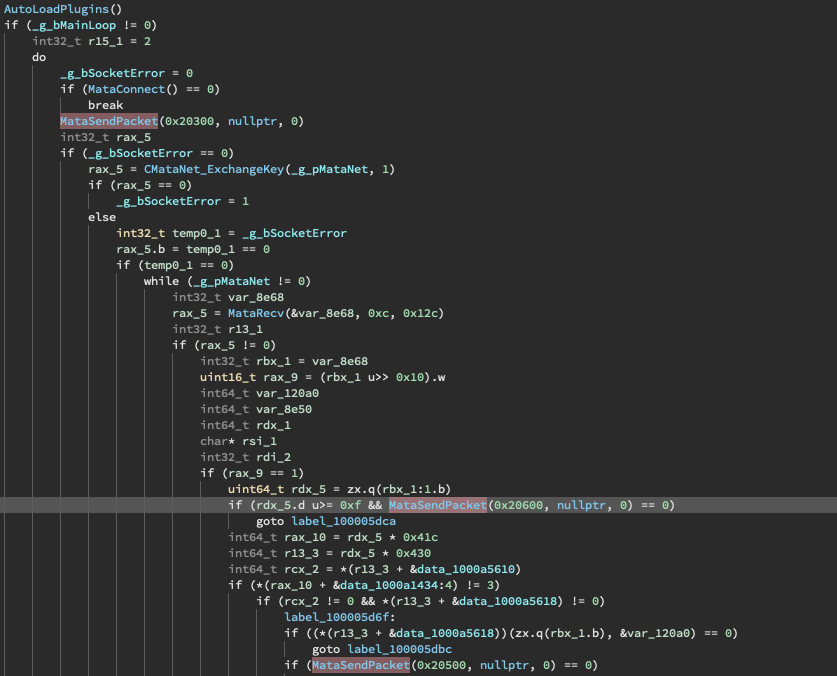

Checking the cross references, we can see nearly all of the constants from Takahiro's research, all in the main loop: 

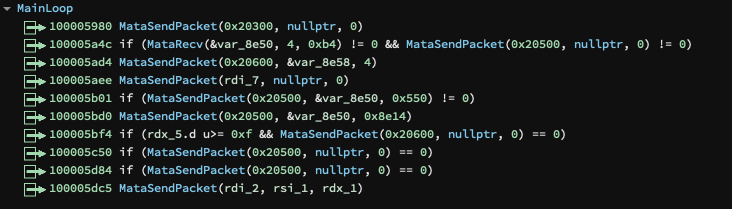

Those opcodes are always moved into EDI, so lets write a rule on some of those basic blocks!

```
rule MAL_MATA_SendPacket_Command_Opcodes
{
		meta:
			author = "Greg Lesnewich"
			date = "2023-01-18"
			version = "1.0"
			description = "check for Mata framework packet opcodes being moved into EDI before sending"

		strings:
				$0x20300 = { bf 00 03 02 00 31 f6 31 d2 e8 }
				$0x20600 = { bf 00 06 02 00 31 f6 49 89 d5 31 d2 e8 }
				$0x20500 = { bf 00 05 02 00 31 f6 31 d2 e8 }
				/*
					100005d7b  bf00050200         mov     edi, 0x20500
					100005d80  31f6               xor     esi, esi  {0x0}
					100005d82  31d2               xor     edx, edx  {0x0}
					100005d84  e867f9ffff         call    MataSendPacket
				*/
		condition:
				(uint32be(0x0) == 0xCAFEBABE or uint32be(0x0) == 0xCFFAEDFE or uint32be(0x0) == 0xCEFAEDFE) and
				all of them
}
```



We can see the other constants in the beacon packet if we use `Ctrl-F` in binja (which runs crazy quick) looking for `0x20100` in the high level IL, which points us to a function called CMataNet_Auth that contains all of those contants: 

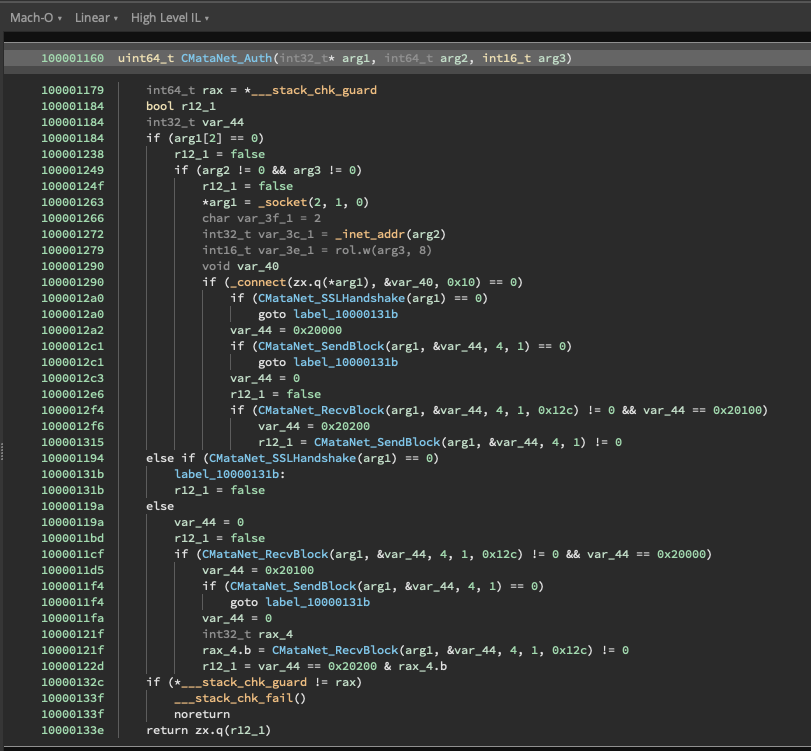

Lets sig this to get the initial reference to 0x20000, checking the return packet for 0x20100, and then loading 0x20200:



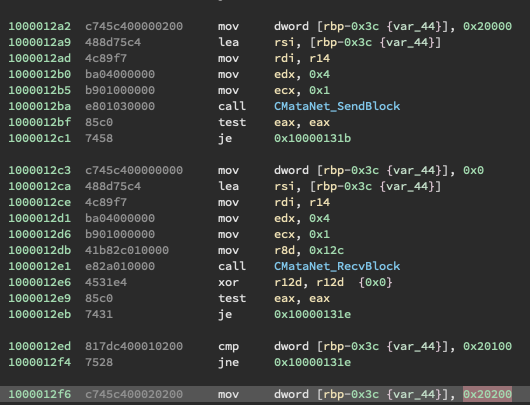

This fortunately all happens in a very compressed amount of space. The only things we'll need to wildcard out are the jump addresses and the call addresses! I like to copy these basic block by basic block to avoid errors but I'll use Atom's multi-line editing to make it easy

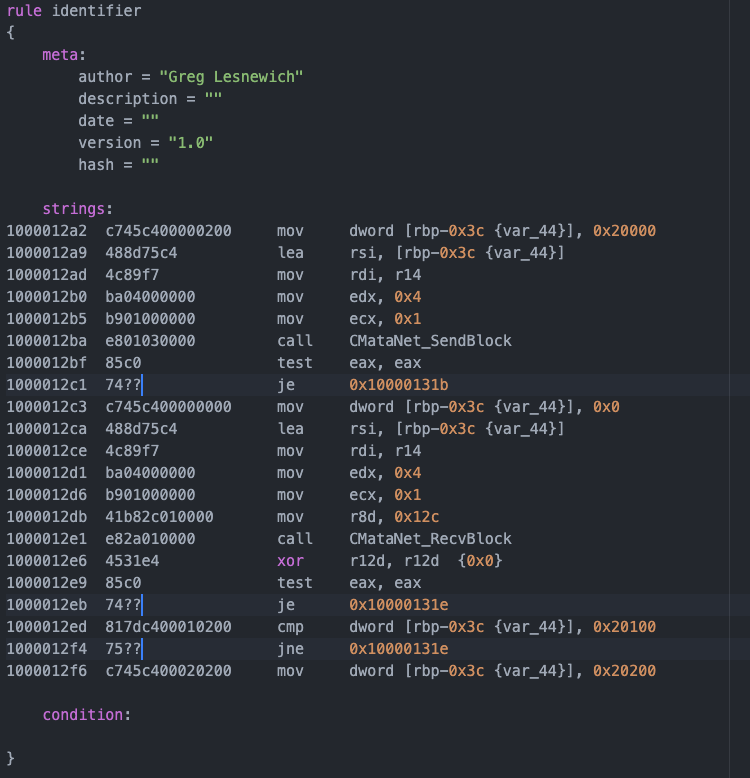

Converting the jump instructions to wild cards

and doing the same with call instructions:



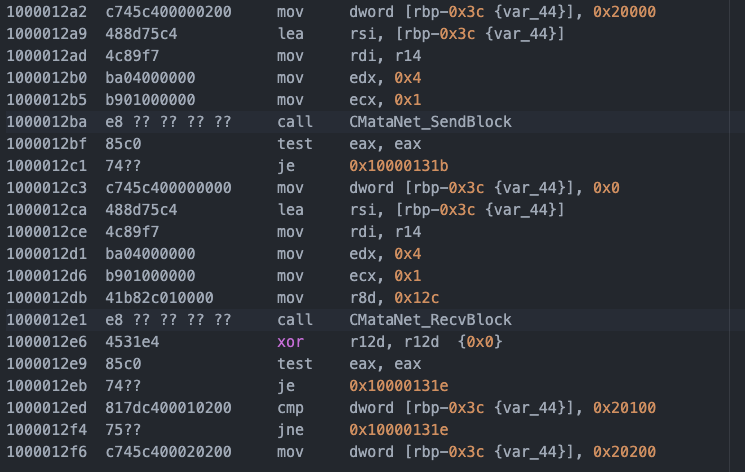

and voila! 

```
rule MAL_MATA_Beacon_Command_Opcodes
{
		meta:
			author = "Greg Lesnewich"
			date = "2023-01-18"
			version = "1.0"
			description = "check for Mata framework beacon opcodes and handshake check"

		strings: 
			$CMataNet_Auth = {
			c745c400000200     //1000012a2  c745c400000200     mov     dword [rbp-0x3c {var_44}], 0x20000
			488d75c4           //1000012a9  488d75c4           lea     rsi, [rbp-0x3c {var_44}]
			4c89f7             //1000012ad  4c89f7             mov     rdi, r14
			ba04000000         //1000012b0  ba04000000         mov     edx, 0x4
			b901000000         //1000012b5  b901000000         mov     ecx, 0x1
			e8????????         //1000012ba  e8????????         call    CMataNet_SendBlock
			85c0               //1000012bf  85c0               test    eax, eax
			74??               //1000012c1  74??               je      0x10000131b
			c745c400000000     //1000012c3  c745c400000000     mov     dword [rbp-0x3c {var_44}], 0x0
			488d75c4           //1000012ca  488d75c4           lea     rsi, [rbp-0x3c {var_44}]
			4c89f7             //1000012ce  4c89f7             mov     rdi, r14
			ba04000000         //1000012d1  ba04000000         mov     edx, 0x4
			b901000000         //1000012d6  b901000000         mov     ecx, 0x1
			41b82c010000       //1000012db  41b82c010000       mov     r8d, 0x12c
			e8????????         //1000012e1  e8????????         call    CMataNet_RecvBlock
			4531e4             //1000012e6  4531e4             xor     r12d, r12d  {0x0}
			85c0               //1000012e9  85c0               test    eax, eax
			74??               //1000012eb  74??               je      0x10000131e
			817dc400010200     //1000012ed  817dc400010200     cmp     dword [rbp-0x3c {var_44}], 0x20100
			75??   						 //1000012f4  75??               jne     0x10000131e
			c745c400020200     //1000012f6  c745c400020200     mov     dword [rbp-0x3c {var_44}], 0x20200
		}

		condition:
			(uint32be(0x0) == 0xCAFEBABE or uint32be(0x0) == 0xCFFAEDFE or uint32be(0x0) == 0xCEFAEDFE) and
			all of them
}
```

That's all for today - tons more to dig into on this sample but only so much usefulness we can milk for signature usage in one blog post. Ta-ta! 